In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
## Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
## Reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
## We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
## Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
## Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

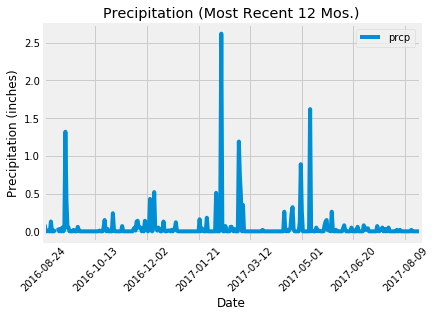

In [10]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results

# PULL ALL PRECIPITATION DATA
prcp = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date.desc()).group_by(Measurement.date).all()

# FIND MOST RECENT DATE 

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# CONVERT DATE AND FIND DATE OF 1 YEAR PRIOR

range_max = pd.DataFrame(latest_date, columns=['date'])
range_max = dt.datetime.strptime(range_max['date'][0], '%Y-%m-%d')
range_min = range_max - dt.timedelta(days=365)

# FILTER FOR DATE RANGE

prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= range_min).\
    filter(Measurement.date <= range_max).\
    order_by(Measurement.date).group_by(Measurement.date).all()


# SAVE INTO DATAFRAME
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'prcp'])

# PLOT

prcp_df.plot(x='date', y='prcp', title="Precipitation (Most Recent 12 Mos.)")
plt.ylabel('Precipitation (inches)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

In [11]:
## Use Pandas to calcualte the summary statistics for the precipitation data

#prcp_df.describe()
prcp_df.agg({'prcp': ['count', 'min', 'max', 'mean', 'median', 'std', 'var']})

,prcp
count,363.000000
min,0.000000
max,2.620000
mean,0.048843
median,0.000000
std,0.205197
var,0.042106


In [12]:
## Design a query to show how many stations are available in this dataset?

stations = session.query(Station.station).all()
station_count = len(stations)

print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [13]:
## List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station_activity_df = pd.DataFrame(station_activity, columns=['station', 'activity count'])

station_activity_df

,station,activity count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [14]:
## What is the most active station? (i.e. what station has the most rows)?

top_station = station_activity_df.iloc[0]

station_id = top_station['station']
station_id

'USC00519281'

In [15]:
## Using the station id from the previous query, calculate the lowest temperature recorded, 
## highest temperature recorded, and average temperature of the most active station?

max = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()

min = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()

avg = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()

print(f"The hightest temperature recorded was {max}")
print(f"The lowest temperature recorded was {min}")
print(f"The average temperature recorded was {avg}")

The hightest temperature recorded was [(85.0,)]
The lowest temperature recorded was [(54.0,)]
The average temperature recorded was [(71.66378066378067,)]


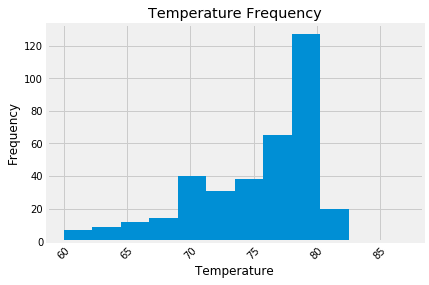

In [16]:
## Choose the station with the highest number of temperature observations.
## Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# PULL MOST ACTIVE STATION DATA
station_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == station_id).order_by(Measurement.date.desc()).all()

# FIND MOST RECENT DATE

station_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).\
    filter(Measurement.station == station_id).first()


# CONVERT DATE AND FIND DATE OF 1 YEAR PRIOR

station_range_max = pd.DataFrame(station_recent, columns=['date'])
station_range_max = dt.datetime.strptime(station_range_max['date'][0], '%Y-%m-%d')
station_range_min = station_range_max - dt.timedelta(days=365)

# FILTER FOR DATE RANGE

temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= station_range_min).\
    filter(Measurement.date <= station_range_max).\
    order_by(Measurement.date).group_by(Measurement.date).all()


# SAVE INTO DATAFRAME
temp_df = pd.DataFrame(temp_data, columns=['date', 'tobs'])

# PLOT HISTOGRAM WITH BINS = 12

temp_df.hist(bins=12)
plt.title('Temperature Frequency')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.xticks(rotation=45)
plt.show()